In [2]:
#data manipulation packages
import pandas as pd
import numpy as np
import scipy
import re
import os, sys, gc, time, warnings, pickle, psutil, random


#visualization tools
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from itertools import cycle

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 400)

In [3]:
sales = pd.read_csv('sales_train_validation.csv')
cal = pd.read_csv('calendar.csv', parse_dates = ['date'])
sales.shape

(30490, 1919)

In this notebook, we will address the large gaps within each item's time series by using Gausian Process Regression. After handling this, we will then address the intermittent demand we see in many of the series. I will explain that process after first handling the missing data.

Below, we are indexing on where we observe the large 0 gaps. if the occur in the beginning, we will reverse our data to train the missing data. If the gaps occur in the middle and end, then we will model the data in its regular order.

In [4]:
'''As observed above, some of the items, for one reason or another, have limited history throughout the time series.
The following script will find the items that have limited history, the amount of consecutive zeros within the time
series, and where exactly they occur in the series (i.e. 'beginning', 'middle', 'end').
'''

import itertools

limited_items = {}
d_cols = [col for col in sales.columns if 'd_' in col]

for item_id in sales['id']:
    df = sales.loc[sales['id'] == item_id][d_cols].T
    df = df.rename(columns={sales.index[sales['id']==item_id].to_list()[0]:item_id}) # Name it correctly
    df = df.reset_index().rename(columns={'index': 'd'}) # make the index "d"
    df = df.merge(cal, how='left', validate='1:1')
    
    rolled = np.asarray(df.iloc[:,1].astype(int))
    
    zero_consec, zero_count = [0], 0
    full_series = []
    
    condition = np.where(rolled==0,'true','false')
    zero_groups = [ sum( 1 for _ in group ) for key, group in itertools.groupby( condition ) if key ]
    zero_gap = (zero_groups.index(max(zero_groups))/len(zero_groups))*100

    if zero_gap<35:
        zero_location = 'beginning'
    elif zero_gap <= 35 or zero_gap<=75:
        zero_location = 'middle'
    else:
        zero_location = 'end'

    for val in range(len(rolled)):
        condition = val == 0
        if rolled[val]==0:
            zero_count+=1
        else:
            if zero_count>zero_consec[0]:
                zero_consec[0] = zero_count
                zero_ind = val-zero_count
            else:
                zero_count = 0
    if zero_consec[0]>100:
        limited_items[item_id] = zero_consec[0], zero_location, zero_ind
    else:
        continue

In [ ]:
#release date could a be a feature in and of itself.

In [5]:
##first 10 items in limited_items

from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

first_ten = take(10, limited_items.items())
first_ten

[('HOBBIES_1_001_CA_1_validation', (916, 'beginning', 2)),
 ('HOBBIES_1_002_CA_1_validation', (150, 'beginning', 2)),
 ('HOBBIES_1_003_CA_1_validation', (1109, 'beginning', 3)),
 ('HOBBIES_1_005_CA_1_validation', (112, 'beginning', 0)),
 ('HOBBIES_1_006_CA_1_validation', (429, 'beginning', 0)),
 ('HOBBIES_1_007_CA_1_validation', (530, 'beginning', 0)),
 ('HOBBIES_1_008_CA_1_validation', (185, 'middle', 543)),
 ('HOBBIES_1_009_CA_1_validation', (143, 'end', 1644)),
 ('HOBBIES_1_010_CA_1_validation', (110, 'beginning', 4)),
 ('HOBBIES_1_011_CA_1_validation', (557, 'beginning', 7))]

In [ ]:
#why would items have there gap in the beginning but not on day zero?

We can see that we've grabbed all of the items that have more than 100 consecutive days without selling an item. Additionally, we've grabbed how large the zero gap is, where in the time series it occured, and at what index the gap begins. This way, we can make a train and test set for a GPR model.

I think the best way to optimize parameters for the model is to aggregate the mean values for each category in a rolling window and do a Bayesian Opt. Hopefully the avg will represent the overall noise of the items within the category and, from there, we will model each item to fill these zero gaps.

In [243]:
temp = sales.copy()
temp['item_cat'] = temp['id'].str.split('_',1).str.get(0).str.lower()
cat_df = temp[temp['item_cat']=='foods'][d_cols].sum().T

# vals = []
# for i in cat_df.mean(axis=0).T:
#     if i<10:
#         vals.append(np.floor(i))
#     else:
#         vals.append(np.ceil(i))
        
cat_totals = cat_df.values
cat_totals

array([23178, 22758, 17174, ..., 26704, 31927, 32654], dtype=int64)

In [266]:
from sklearn.gaussian_process import GaussianProcessRegressor
from hyperopt import rand, tpe
from hyperopt import Trials

X = cat_totals[:int(len(cat_totals)*.5)].reshape(-1, 1)
y = cat_totals[int(len(cat_totals)*.5):].reshape(-1, 1)
y = y[1:]
                                        
tpe_algo = tpe.suggest
tpe_trials = Trials()
                                        
print(X.shape[0])
print(y.shape[0])

956
956


In [267]:
from numpy.random import normal

def objective(Y, noise=0.1):
	noise = normal(loc=0, scale=noise)
	return Y + noise

In [268]:
X = X - X.mean()

y = [objective(Y, 0) for Y in y]

X = np.array(X).reshape(len(X), 1)
y = np.array(y).reshape(len(y), 1)

In [235]:
gp = GaussianProcessRegressor()

gp.fit(X,y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [269]:
# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
	# calculate the best surrogate score found so far
	yhat, _ = surrogate(model, X)
	best = max(yhat)
	# calculate mean and stdev via surrogate function
	mu, std = surrogate(model, Xsamples)
	mu = mu[:, 0]
	# calculate the probability of improvement
	probs = norm.cdf((mu - best) / (std+1E-9))
	return probs

def objective(params, noise=.1):
    gp = GaussianProcessRegressor(params)
    noise = normal(loc=0, scale=noise)
    score = (x**2 * np.cos(5 * math.pi * x)**6.0)+noise
    return score
  
def surrogate(gp, X):
	with catch_warnings():
		# ignore generated warnings
		simplefilter("ignore")
		return gp.predict(X, return_std=True)
    
def opt_acquisition(X, y, model):
	# random search, generate random samples
	Xsamples = random(100)
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	# calculate the acquisition function for each sample
	scores = acquisition(X, Xsamples, model)
	# locate the index of the largest scores
	ix = max(scores)
	return Xsamples[ix, 0]

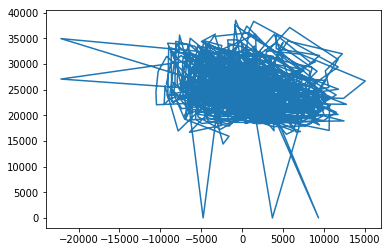

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [271]:
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from warnings import catch_warnings
from warnings import simplefilter
# plot real observations vs surrogate function
def plot(X, y, model):
	# scatter plot of inputs and real objective function
	plt.plot(X, y)
	plt.show()
 
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot before hand
plot(X, y, model)
# perform the optimization process
for i in range(100):
	# select the next point to sample
	x = opt_acquisition(X, y, model)
	# sample the point
	actual = objective(x)
	# summarize the finding
	est, _ = surrogate(model, [[x]])
	print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
	# add the data to the dataset
	X = vstack((X, [[x]]))
	y = vstack((y, [[actual]]))
	# update the model
	model.fit(X, y)


plot(X, y, model)
# best result
ix = max(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))


In [217]:
def evaluate_model(**params):
	# something
	model = GaussianProcessRegressor(**params)
	# calculate 5-fold cross validation
	result = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='accuracy')
	# calculate the mean of the scores
	estimate = mean(result)
	return 1.0 - estimate


In [ ]:
from hyperopt import fmin
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from hyperopt import hp, STATUS_OK
from hyperopt.pyll import scope
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import math

space = hp.uniform('x', -5, 6)


params = {
    'kernal':hp.uniform('kernal',C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))),
     'objective':hp.choice('objective',['fmin_l_bfgs_b']),
     'alpha': hp.quniform('alpha',np.linspace(.01,2,5)),
     'n_restarts_optimizer':hp.quniform('n_restarts_optimizer',1,3,5,7),
                        }




In [218]:
from skopt import gp_minimize
search_space = [(1, 5), (1, 2)]
result = gp_minimize(evaluate_model(), search_space)

ValueError: continuous is not supported

In [172]:
tpe_best = fmin(fn=objective, space=space, algo=tpe_algo, trials=tpe_trials, 
                max_evals=2000, rstate= np.random.RandomState(50))

print(tpe_best)

  0%|                                                                         | 0/2000 [00:00<?, ?trial/s, best loss=?]

job exception: cannot convert dictionary update sequence element #0 to a sequence



TypeError: cannot convert dictionary update sequence element #0 to a sequence

In [ ]:
# a possible feature could be the number of spikes the item has seen, or zero demand days.